# Broker, Informed, Noise Traders: Filtering Game

In [1]:
import sys
import utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
reload(utils)

C:\Users\muham\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<module 'utils' from 'D:\\(Akademik)\\(CDT in Mathematics of Random Systems)\\[Broker, Informed, Noise Traders, Filtering Game]\\utils.py'>

In [2]:
%load_ext autoreload
%autoreload 2
np.random.seed(100)

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

## 1. Choose the signal filtering strategy & benchmark

In [4]:
# choosing strategy type
# available strategies are "our model", "alternative filter", "naive filter"
# mispecify parameter represents whether the broker mispecifies the informed trader's inventory or not

strategy_type = "naive filter"
mispecify = False
file_name = f'{strategy_type}'
if mispecify:
    file_name += f' (mispecified inventory)'
    
alpha_est_name = {"our model": r'$\hat{\alpha}_t$',
                  "alternative filter": r'$\hat{\alpha}^{alt}_t$',
                  "naive filter": r'$\tilde{\alpha}_t$'}

## 2. Set the parameters & functions involved

In [37]:
# high signal-to-noise ratio

scale_ivp = 100000

params_env = {'b': 2, 'alpha0': 0, 'kappa_alpha': 1, 'sigma_alpha': 50., 
              'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

env = utils.environment(**params_env)

params_inf = {'env': env, 'Q0' : 0., 'k' : 4, 'beta0' : 1e-2, 'beta1' : 1e-4, 'rho0' : 5e-2, 'rho1' : 1e-5,
                  'sigma_B' : 7., 'mu_B' : 0., 'theta_B' : 0.2, 'sigma_0' : 0}

inf_trader =  utils.informed(**params_inf)

params_uninf = {'kappa' : 5., 'nu0' : 0., 'sigma' : 10., 'k' : 4}

uninf_trader = utils.uninformed(**params_uninf)

params_broker = {'env': env, 'inf': inf_trader, 'uninf': uninf_trader,
                 'Q0': 0, 'k': 4.2, 'beta0': 1000, 'beta1': 10, 'rho0': 10, 'rho1': 1e-01, 
                 'sigma_B': inf_trader.sigma_B, 'mu_B': inf_trader.mu_B, 'theta_B': inf_trader.theta_B, 
                 'sigma_0': 0, 'scale_ivp' : scale_ivp}

broker = utils.broker(**params_broker)

D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:212: RuntimeWarning: divide by zero encountered in divide
  GF0 = -(env.b/env.sigma_s)**2 * V_I - f3/2 - (env.b/(2*inf.k*f2))
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:226: RuntimeWarning: invalid value encountered in divide
  GF6 = -(dGF3 * (GF3 + env.corr*GF4) + dGF3 * (env.corr * GF3 + GF4))/(GF5**2)
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:229: RuntimeWarning: invalid value encountered in divide
  GF7 = GF_alpha/GF5
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:232: RuntimeWarning: invalid value encountered in divide
  kF = (GF3 + env.corr * GF4)/GF5


## 2a. Check the Freiling condition

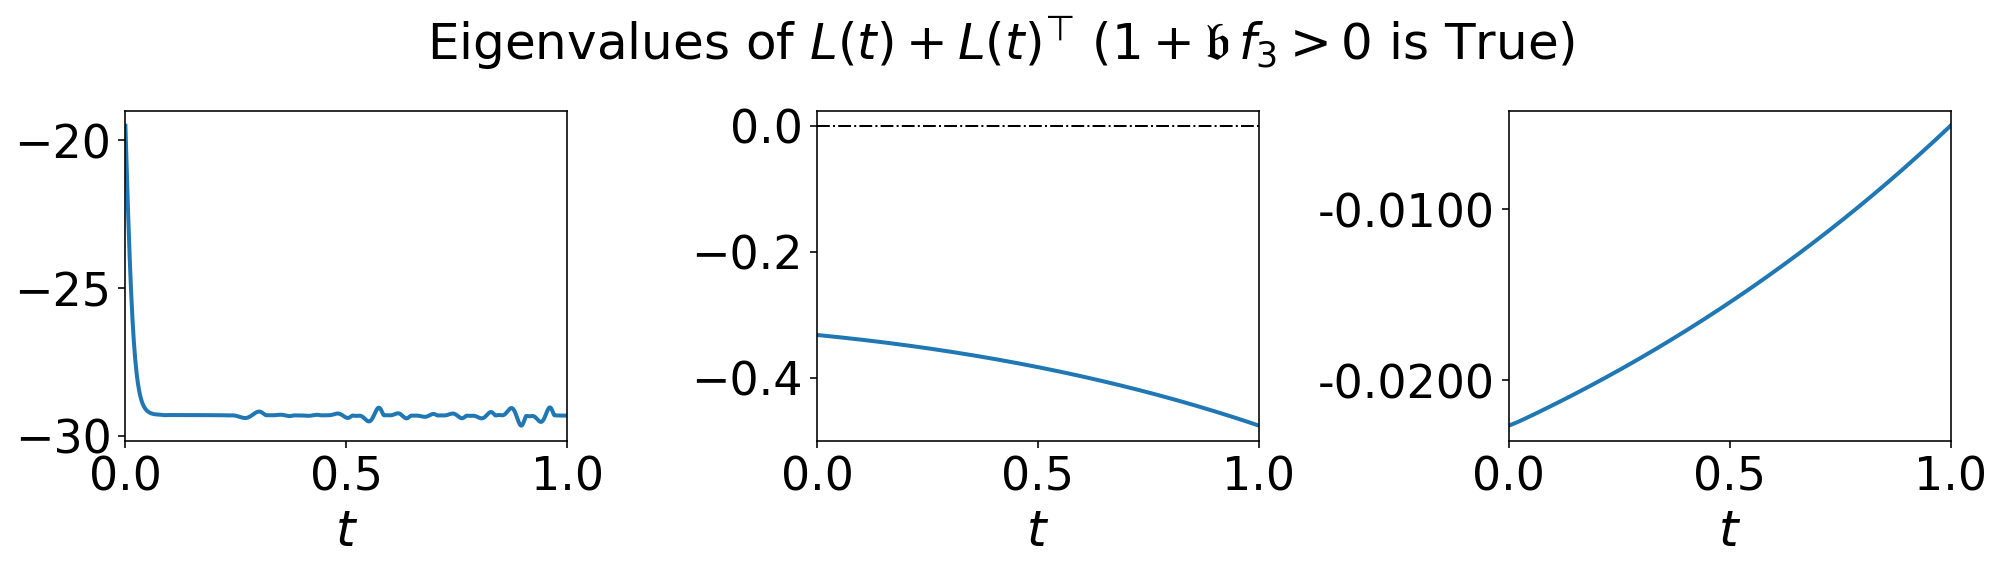

In [38]:
import freiling as freiling

freiling.freiling(env, inf_trader, broker)

In [39]:
z = inf_trader.z
f2 = z[2] / 2 / inf_trader.k
f1 = z[1] / 2 / inf_trader.k

constraint = broker.k - inf_trader.k*f2**2

constraint.min()

3.99571820840074

## 3. Simulate all the Brownian, signal, and noise traders' paths

In [40]:
nsims = 10_000

W = env.simulate_BM_with_drift(x0=0, mu=0, sigma=1, nsims=nsims)
alpha = env.simulate_alpha(nsims = nsims)
nu_U = uninf_trader.simulate_uninformed_flow(env, nsims=nsims)

## 4. Simulate the informed trader & broker's strategies

In [41]:
import simulations as simulations

In [42]:
model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                               W, alpha, nu_U, 
                               strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

## 5. Plot the results

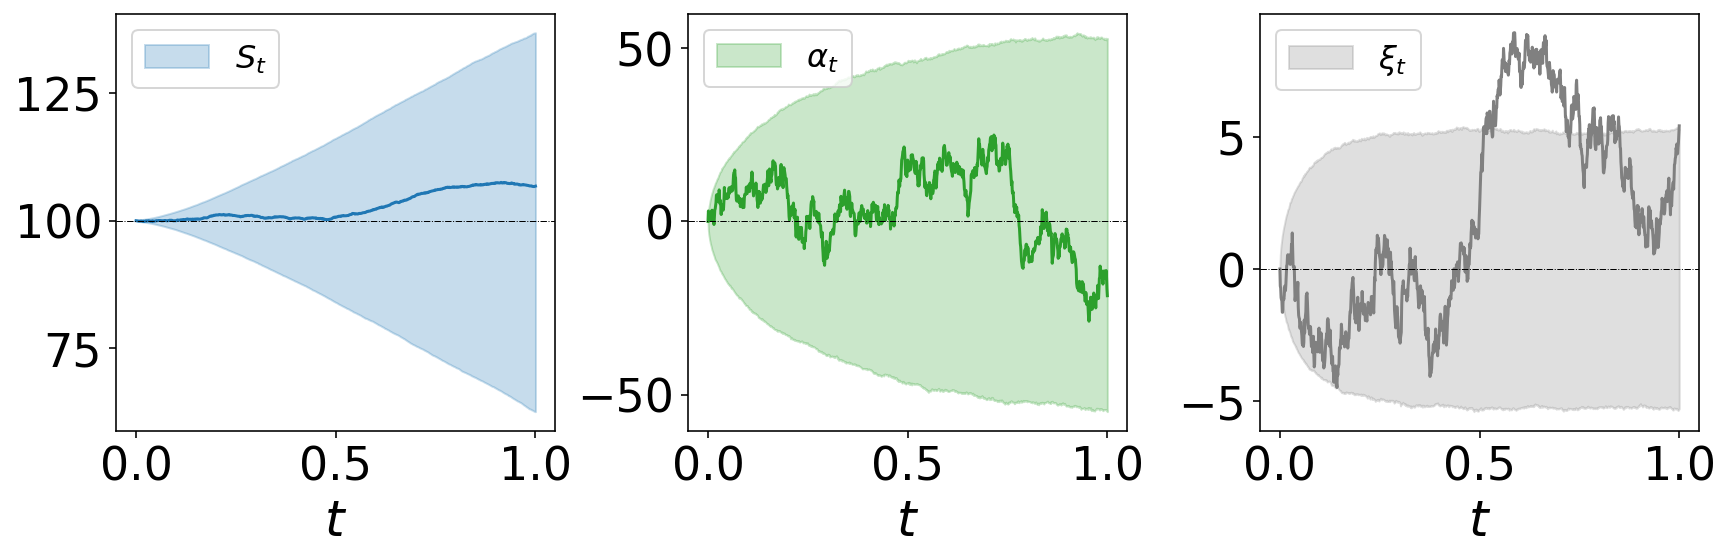

In [43]:
qtl_S = np.quantile(model.S,[0.05,0.5,0.95], axis=1)
qtl_alpha = np.quantile(alpha,[0.05,0.5,0.95], axis=1)
qtl_nu_U = np.quantile(nu_U,[0.05,0.5,0.95], axis=1)

t = env.timesteps

font1 = 25
font2 = 23
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].fill_between(t,qtl_S[0],qtl_S[-1],alpha=0.25, label=r'$S_t$', color='tab:blue')
ax[0].plot(t, model.S[:,1], markevery=100,color='tab:blue')
ax[0].legend(fontsize=16,loc='upper left')

ax[1].fill_between(t,qtl_alpha[0],qtl_alpha[-1],alpha=0.25, label=r'$\alpha_t$', color='tab:green')
ax[1].plot(t, alpha[:,1], markevery=100,color='tab:green')
ax[1].legend(fontsize=16,loc='upper left')

ax[2].fill_between(t,qtl_nu_U[0],qtl_nu_U[-1],alpha=0.25, label=r'$\xi_t$', color='gray')
ax[2].plot(t, nu_U[:,1], markevery=100,color='gray')
ax[2].legend(fontsize=16,loc='upper left')

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(env.S0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/env {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

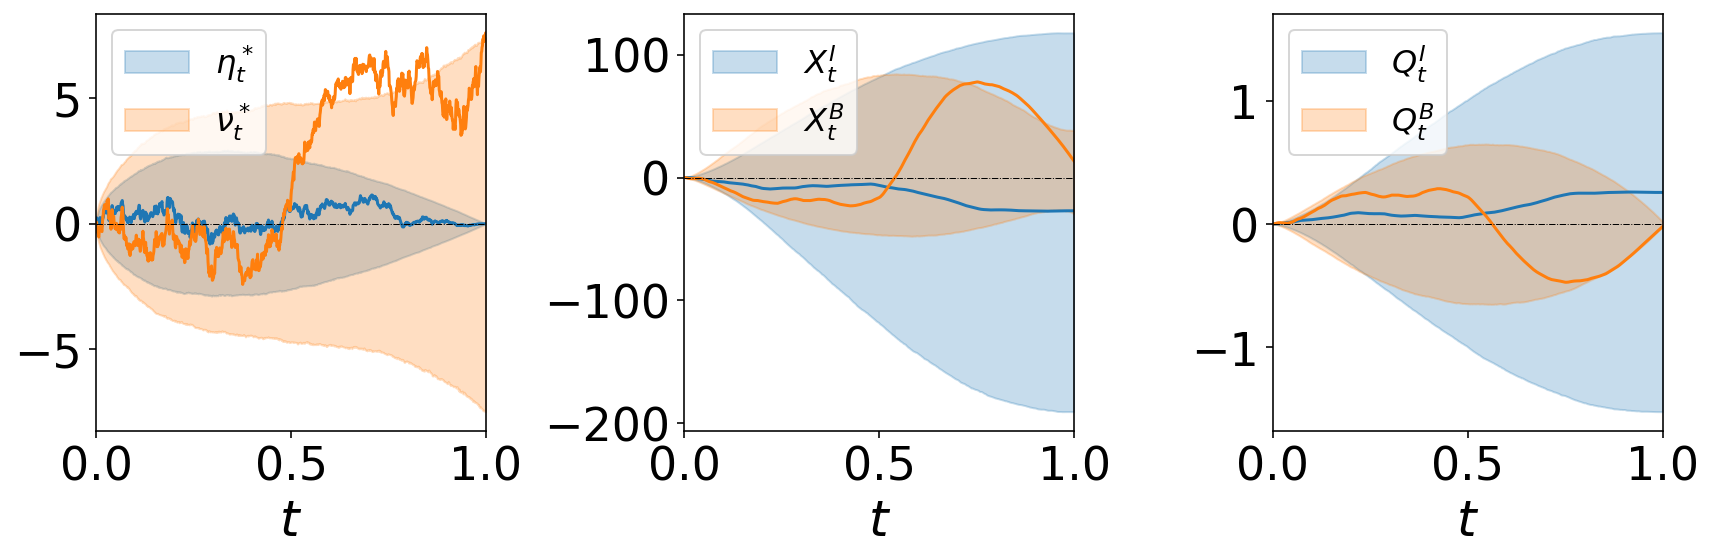

In [44]:
# informed & broker's speed

t = env.timesteps

fig, ax = plt.subplots(1, 3, figsize=(12,4))
font1 = 25
font2 = 23

qtl_nu_I = np.quantile(model.nu_I,[0.05,0.5,0.95], axis=1)
qtl_nu_B = np.quantile(model.nu_B,[0.05,0.5,0.95], axis=1)

qtl_X_I = np.quantile(model.X_I,[0.05,0.5,0.95], axis=1)
qtl_X_B = np.quantile(model.X_B,[0.05,0.5,0.95], axis=1)

qtl_Q_I = np.quantile(model.Q_I,[0.05,0.5,0.95], axis=1)
qtl_Q_B = np.quantile(model.Q_B,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^*$', color='tab:blue')
ax[0].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^*$', color='tab:orange')
ax[0].plot(t, model.nu_I[:,1], markevery=100,color='tab:blue')
ax[0].plot(t, model.nu_B[:,1], markevery=100,color='tab:orange')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0.,1)

ax[1].fill_between(t,qtl_X_I[0],qtl_X_I[-1],alpha=0.25, label=r'$X_t^I$', color='tab:blue')
ax[1].fill_between(t,qtl_X_B[0],qtl_X_B[-1],alpha=0.25, label=r'$X_t^B$', color='tab:orange')
ax[1].plot(t, model.X_I[:,1], markevery=100,color='tab:blue')
ax[1].plot(t, model.X_B[:,1], markevery=100,color='tab:orange')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)

ax[2].fill_between(t,qtl_Q_I[0],qtl_Q_I[-1],alpha=0.25, label=r'$Q_t^I$', color='tab:blue')
ax[2].fill_between(t,qtl_Q_B[0],qtl_Q_B[-1],alpha=0.25, label=r'$Q_t^B$', color='tab:orange')
ax[2].plot(t, model.Q_I[:,1], markevery=100,color='tab:blue')
ax[2].plot(t, model.Q_B[:,1], markevery=100,color='tab:orange')
ax[2].set_xlabel(r'$t$',fontsize=16)
ax[2].legend(fontsize=16,loc='upper left')
ax[2].set_xlim(0,1)

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/speed cash inventory {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

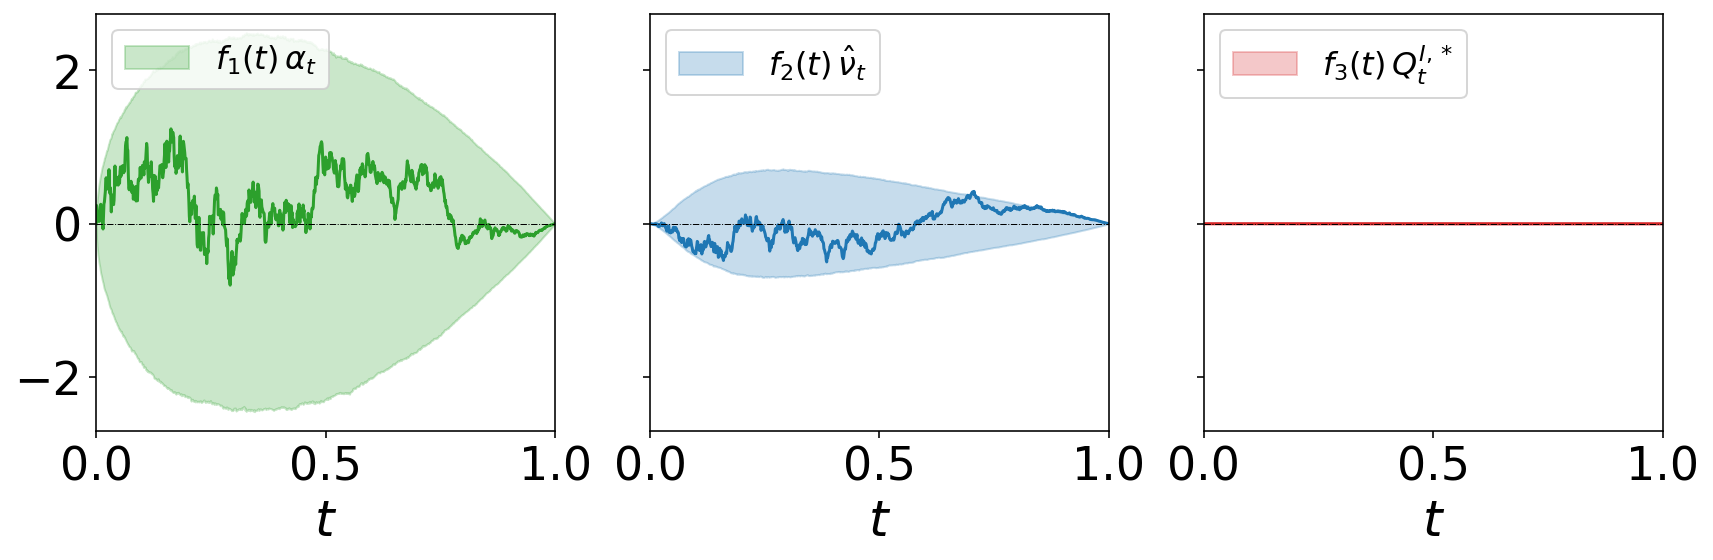

In [45]:
# plot the components of trader's speed

t = env.timesteps

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey='row')

z = inf_trader.z
f3 = z[9] / inf_trader.k
f2 = z[2] / 2 / inf_trader.k
f1 = z[1] / 2 / inf_trader.k
f0 = z[0] / 2 / inf_trader.k

nu_I_0 = f0
nu_I_alpha = ((f1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.alpha
nu_I_nu_B_hat = ((f2.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.nu_B_hat
nu_I_Q_I = ((f3.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.Q_I

nu_I_alpha_qtl = np.quantile(nu_I_alpha,[0.05,0.5,0.95], axis=1)
nu_I_nu_B_hat_qtl = np.quantile(nu_I_nu_B_hat,[0.05,0.5,0.95], axis=1)
nu_I_Q_I_qtl = np.quantile(nu_I_Q_I,[0.05,0.5,0.95], axis=1)

nu_B_hat_qtl = np.quantile(model.nu_B_hat,[0.05,0.5,0.95], axis=1)
alpha_qtl = np.quantile(model.alpha,[0.05,0.5,0.95], axis=1)
Q_I_qtl = np.quantile(model.Q_I,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,nu_I_alpha_qtl[0],nu_I_alpha_qtl[-1], alpha=0.25, label=r'$f_1(t)\, \alpha_t$', color='tab:green')
ax[0].plot(t, nu_I_alpha[:,1], markevery=100, color='tab:green')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,1].set_ylim(y_lim_1)

ax[1].fill_between(t,nu_I_nu_B_hat_qtl[0],nu_I_nu_B_hat_qtl[-1], alpha=0.25, label=r'$f_2(t)\, \hat{\nu}_t$', color='tab:blue')
ax[1].plot(t, nu_I_nu_B_hat[:,1], markevery=100, color='tab:blue')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,2].set_ylim(y_lim_1)

ax[2].fill_between(t,nu_I_Q_I_qtl[0],nu_I_Q_I_qtl[-1], alpha=0.25, label=r'$f_3(t)\, Q_t^{I,*}$', color='tab:red')
ax[2].plot(t, nu_I_Q_I[:,1], markevery=100, color='tab:red')
ax[2].set_xlabel(r'$t$',fontsize=16)
ax[2].legend(fontsize=16,loc='upper left')
ax[2].set_xlim(0,1)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,3].set_ylim(y_lim_1)


ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)


plt.tight_layout()
plt.savefig(f'figures/nuI coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

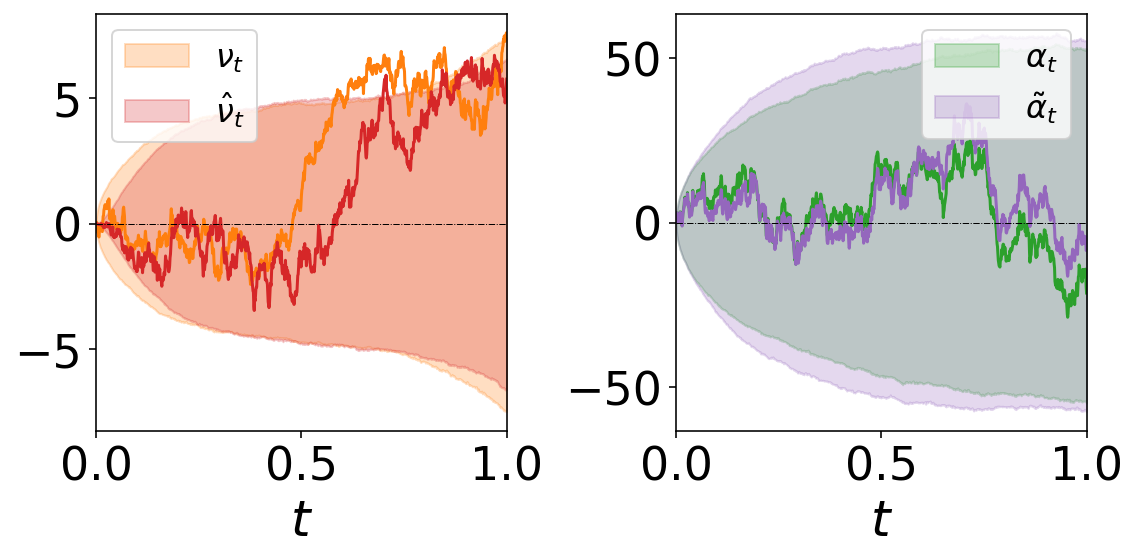

In [46]:
t = env.timesteps
sim = 1
fig, ax = plt.subplots(1, 2, figsize=(8,4))

qtl_alpha = np.quantile(model.alpha,[0.05,0.5,0.95], axis=1)
qtl_alpha_hat = np.quantile(model.alpha_hat,[0.05,0.5,0.95], axis=1)

qtl_nu_B = np.quantile(model.nu_B,[0.05,0.5,0.95], axis=1)
qtl_nu_B_hat = np.quantile(model.nu_B_hat,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t$', color='tab:orange')
ax[0].fill_between(t,qtl_nu_B_hat[0],qtl_nu_B_hat[-1],alpha=0.25, label=r'$\hat{\nu}_t$', color='tab:red')
ax[0].plot(t, model.nu_B[:,sim], markevery=100,color='tab:orange')
ax[0].plot(t, model.nu_B_hat[:,sim], markevery=100,color='tab:red')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
#plt.ylim(-4,4)

ax[1].fill_between(t,qtl_alpha[0],qtl_alpha[-1],alpha=0.25, label=r'$\alpha_t$', color='tab:green')
ax[1].plot(t, model.alpha[:,1], markevery=100,color='tab:green')
ax[1].fill_between(t,qtl_alpha_hat[0],qtl_alpha_hat[-1],alpha=0.25, label=alpha_est_name[strategy_type], color='tab:purple')
ax[1].plot(t, model.alpha_hat[:,1], markevery=100,color='tab:purple')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper right')
ax[1].set_xlim(0,1)

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/filtering {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [47]:
state_B = {1:(model.Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
           2:(model.alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
           3:(model.nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
           4:(model.Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

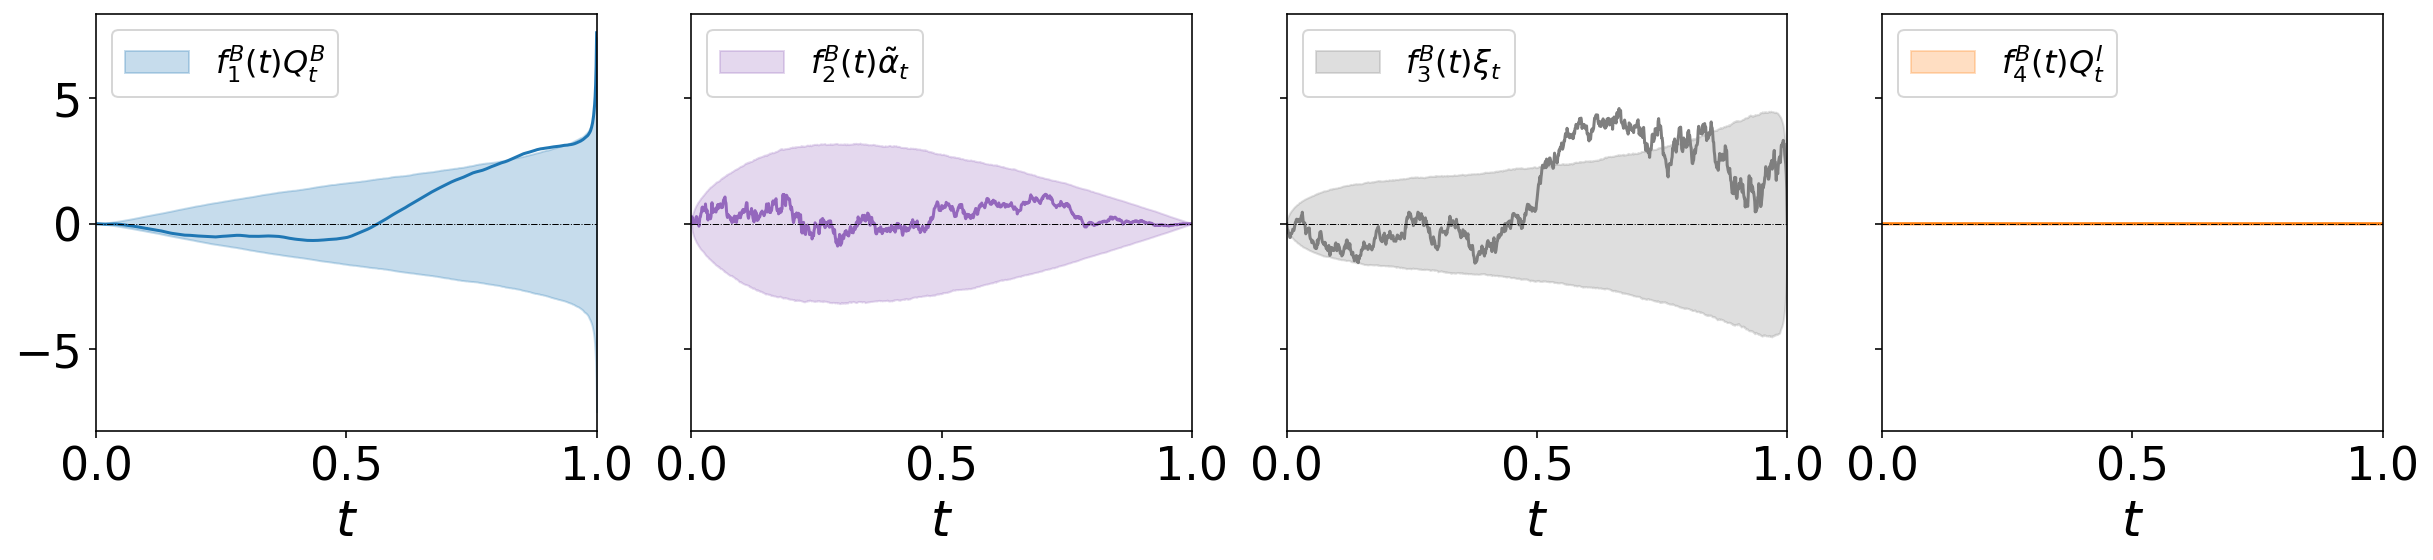

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(17,4), sharey='row')
t = env.timesteps

for j, (var_name, var_label_1, var_label_2, colour) in state_B.items():
    
    coef_var = broker.coef_speed_B[:, 0, j]
    var_name_qtl = np.quantile(var_name,[0.05,0.5,0.95], axis=1)
    
    nu_B_var = ((coef_var.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name
    nu_B_var_qtl = np.quantile(nu_B_var,[0.05,0.5,0.95], axis=1)
    
    ax[j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=var_label_1 + var_label_2, color=colour)
    ax[j-1].plot(t, nu_B_var[:,1], color=colour)
    ax[j-1].set_xlabel(r'$t$',fontsize=16)
    ax[j-1].legend(fontsize=16,loc='upper left')
    ax[j-1].set_xlim(0,1)
    ax[j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
    
ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)
ax[3].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)
ax[3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

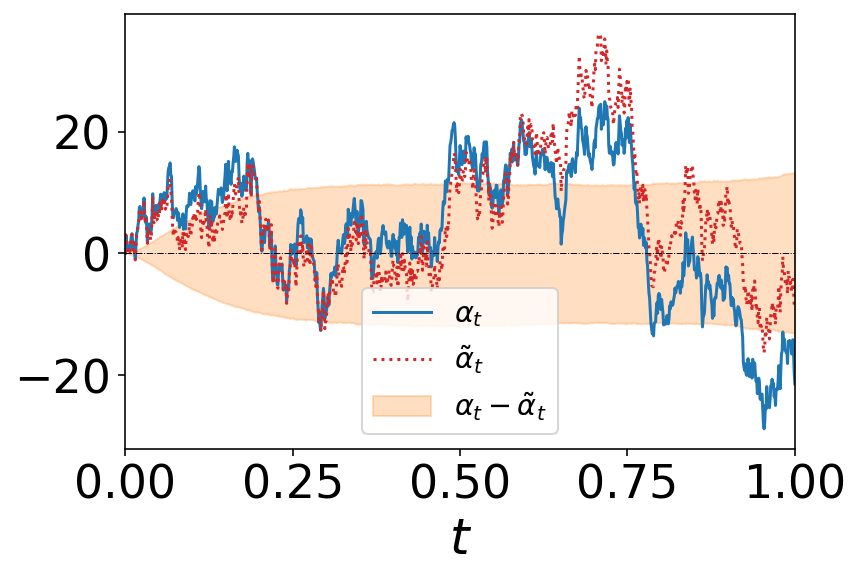

In [49]:
sim_num = 1

alpha_diff = model.alpha - model.alpha_hat
qtl_alpha_diff = np.quantile(alpha_diff,[0.05,0.5,0.95], axis=1)

plt.plot(env.timesteps[:], model.alpha[:, sim_num], label=r'$\alpha_t$')
plt.plot(env.timesteps[:], model.alpha_hat[:, sim_num], label=alpha_est_name[strategy_type], color='tab:red', linestyle = ':')
plt.fill_between(env.timesteps[:], qtl_alpha_diff[0],qtl_alpha_diff[-1],alpha=0.25, label=(r'$\alpha_t - $' + alpha_est_name[strategy_type]), color='tab:orange')
plt.axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
plt.xlim(0,1)

y_ax = 100
#plt.ylim(-y_ax,y_ax)
plt.xlabel(r'$t$', fontsize = font1)
plt.tick_params(axis='both', which='major', labelsize=font2)
plt.legend()
plt.savefig(f'figures/alpha {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

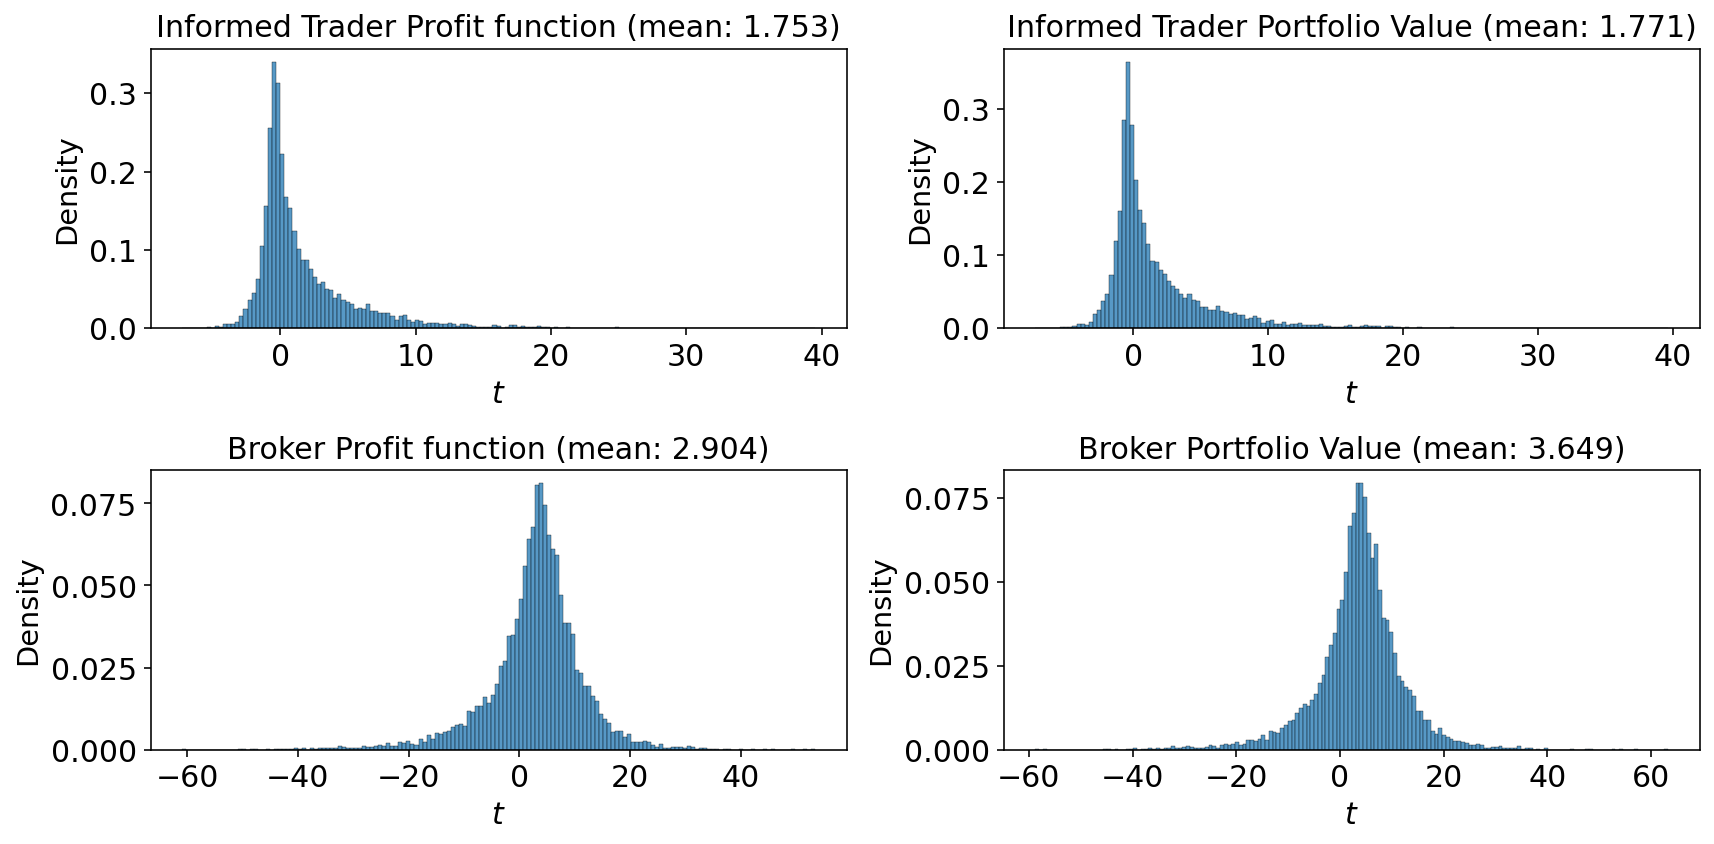

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
t = env.timesteps

font3 = 15

sns.histplot(model.H_I[0,:], stat='density', ax=ax[0, 0])
ax[0, 0].set_title(f'Informed Trader Profit function (mean: {model.H_I[0,:].mean():.3f})', fontsize=font3)

sns.histplot(model.H_B[0,:], stat='density', ax=ax[1, 0])
ax[1, 0].set_title(f'Broker Profit function (mean: {model.H_B[0,:].mean():.3f})', fontsize=font3)

sns.histplot(model.Portfolio_I, stat='density', ax=ax[0, 1])
ax[0, 1].set_title(f'Informed Trader Portfolio Value (mean: {model.Portfolio_I.mean():.3f})', fontsize=font3)

sns.histplot(model.Portfolio_B, stat='density', ax=ax[1, 1])
ax[1, 1].set_title(f'Broker Portfolio Value (mean: {model.Portfolio_B.mean():.3f})', fontsize=font3)

for axes in ax.reshape(-1):
    axes.set_xlabel(r'$t$', fontsize = font3)
    axes.tick_params(axis='both', which='major', labelsize=font3)

plt.tight_layout()
plt.show()

## 6. Compute the outperformance & test whether it outperforms the benchmark

T-test for outperformance w.r.t benchmark 1
T statistic: 49.5986730326607
P-value: 0.0 

T-test for outperformance w.r.t benchmark 2
T statistic: 55.97169422772367
P-value: 0.0 

T-test for outperformance w.r.t benchmark 3
T statistic: 143.74985504204938
P-value: 0.0 



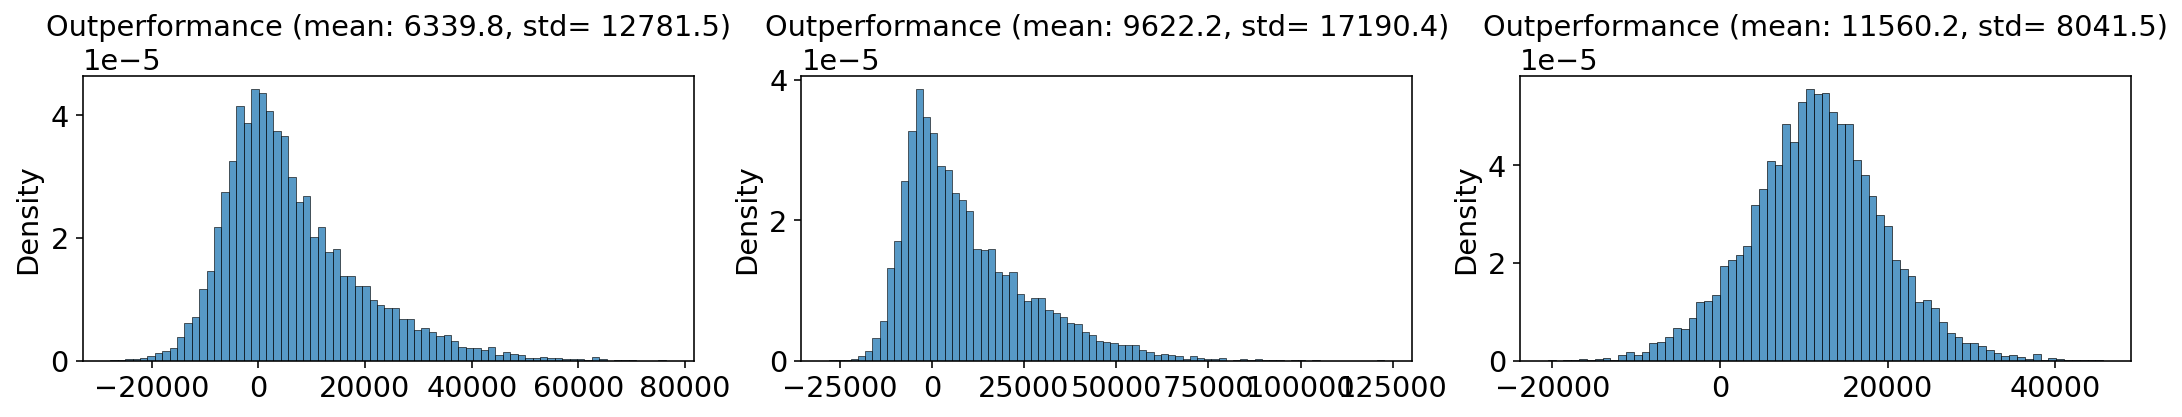

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
t = env.timesteps

benchmarks = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])
outperform = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])

for i, bench in enumerate(benchmarks.keys()):
    benchmarks[bench] = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                               W, alpha, nu_U, 
                                               strategy = bench, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    outperform[bench] = 1e06*((model.Portfolio_B - benchmarks[bench].Portfolio_B)/benchmarks[bench].total_value_traded).reshape((-1,))
    sns.histplot(outperform[bench], stat='density', ax=ax[i])
    ax[i].set_title(f'Outperformance (mean: {outperform[bench].mean():.1f}, std= {outperform[bench].std():.1f})')
    
    t_stat, p_value = stats.ttest_1samp(outperform[bench], 0, alternative='greater')
    print(f"T-test for outperformance w.r.t benchmark {i+1}")
    print("T statistic:", t_stat)
    print("P-value:", p_value, "\n")
    
plt.tight_layout()
plt.savefig(f'figures/outperform {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

## 7. Plot the quality of the alpha filter

In [20]:
var_alpha_obs = (1/(nsims-1))*np.diag((model.alpha - model.alpha_hat)@((model.alpha - model.alpha_hat).T))

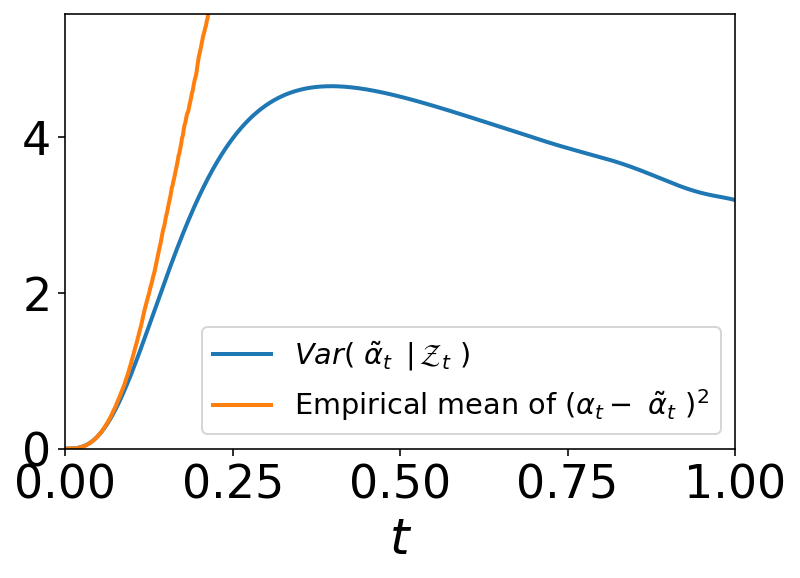

In [21]:
stepback = 1

plt.plot(env.timesteps[:-stepback], model.V_B[:-stepback], label=r'$Var($ ' + alpha_est_name[strategy_type] + r' $\, |\, \mathcal{Z}_t$ )', linewidth=2)
plt.plot(env.timesteps[:-stepback], var_alpha_obs[:-stepback], label=rf'Empirical mean of $(\alpha_t - $ {alpha_est_name[strategy_type]} $)^2$', linewidth=2)
plt.legend()
plt.xlabel(r'$t$', fontsize = font1)
plt.tick_params(axis='both', which='major', labelsize=font2)
plt.xlim(0,1)
plt.ylim(0,1.2*model.V_B.max())
plt.show()

## 8. Comparing the alternative optimal filter to naive filter

In [22]:
alt_filter = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                               W, alpha, nu_U, 
                               strategy = "alternative filter", mispecify = False, mispecify_scale = 1, nsims = nsims)

naive_filter = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                               W, alpha, nu_U, 
                               strategy = "naive filter", mispecify = False, mispecify_scale = 1, nsims = nsims)

D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\simulations.py:114: RuntimeWarning: divide by zero encountered in divide
  self.Z_tilde[i+1, :] = self.gamma_tilde[i+1, :]/broker.GF5[i+1]
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\simulations.py:114: RuntimeWarning: invalid value encountered in divide
  self.Z_tilde[i+1, :] = self.gamma_tilde[i+1, :]/broker.GF5[i+1]


T-test for outperformance of alternative optimal filter to naive filter
T statistic: 38.26461986142344
P-value: 2.1588469236177786e-299 



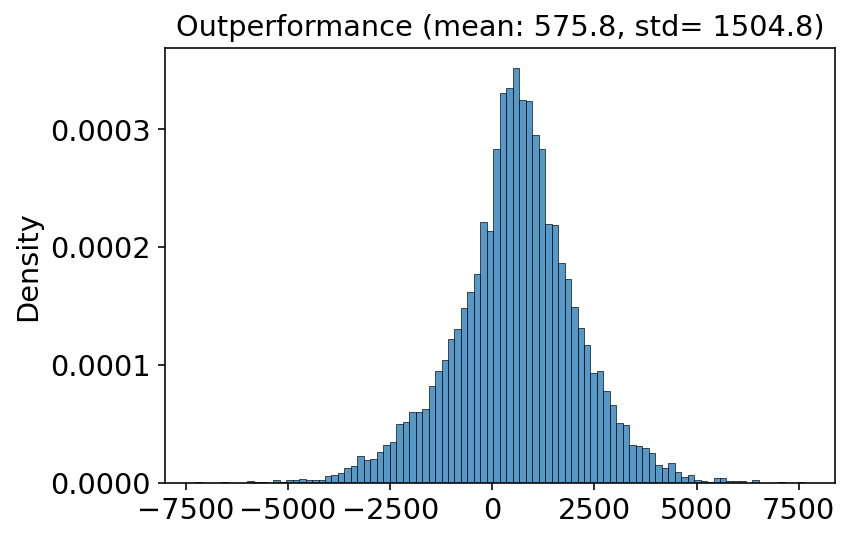

In [23]:
outperform_alt_to_naive = 1e06*((alt_filter.Portfolio_B - naive_filter.Portfolio_B)/naive_filter.total_value_traded).reshape((-1,))
sns.histplot(outperform_alt_to_naive, stat='density')
plt.title(f'Outperformance (mean: {outperform_alt_to_naive.mean():.1f}, std= {outperform_alt_to_naive.std():.1f})')

t_stat, p_value = stats.ttest_1samp(outperform_alt_to_naive, 0, alternative='greater')
print(f"T-test for outperformance of alternative optimal filter to naive filter")
print("T statistic:", t_stat)
print("P-value:", p_value, "\n")